### Setup Models

In [12]:
# LLM packages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Agentic AI packages
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

# LangGraph packges
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

import pandas as pd
import os
from typing import TypedDict, Annotated
import operator
from IPython.display import Image
import json
import uuid
from dotenv import load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')



In [2]:
# Start the LLM and embeddings
model = ChatOpenAI(
    model = "gpt-4o",
    openai_api_key = OPENAI_API_KEY
)

embedding = OpenAIEmbeddings(
    model = "text-embedding-3-large",
)

### Load laptop product orders into pandas dataframe

In [3]:
product_orders_df = pd.read_csv("..//data//Laptop Orders.csv")
product_orders_df.head()

,Order ID,Product Ordered,Quantity Ordered,Delivery Date
0,ORD-8276,SpectraBook S,3,2024-10-16
1,ORD-6948,OmegaPro G17,3,2024-10-25
2,ORD-7311,NanoEdge Flex,2,2024-10-19
3,ORD-4633,OmegaPro G17,2,2024-10-15
4,ORD-2050,GammaAir X,2,2024-10-26


### Create the tools

#### Tool: Get order details from order DB

In [29]:
@tool
def get_order_details(order_id: str) -> str:
    """
    This function returns details about a laptop order, given an order ID.
    It performs an exact match between the input order id and available order ids.
    If a match is found, it returns a dictionary of products (laptops) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    # filter dataframe for order id
    match_order_df = product_orders_df[product_orders_df["Order ID"]== order_id]

    # check if a record was found if not return -1
    if len(match_order_df) == 0:
        return -1
    else:
        return match_order_df.iloc[0].to_dict()

#### Tool: Update quantity in Orders DB

In [30]:
@tool
def update_quantity(order_id: str, new_quantity: int) -> bool:
    """
    This function updates the quantity of products (laptops) ordered for a given order id.
    If there are no matching orders, it returns False
    """
    # filter dataframe for order id
    match_order_df = product_orders_df[product_orders_df["Order ID"]== order_id]

    # check if a record was found if not return -1
    if len(match_order_df) == 0:
        return False
    else:
        product_orders_df.loc[product_orders_df["Order ID"] == order_id,"Quantity Ordered"] = new_quantity
        return True
            

### Create the Custom Agent Graphs

#### Define the State

##### An Agent State Class keeps the state of the agent while it answers a query
- Annotated: This is used to add metadata as the TYPE HINT
- list[AnyMessage]: This indicates that 'messages' is a list of HumanMessage, AIMessage or SystemMessage
- operator.add : Specifies that new messages should be added to the end of the list

In [31]:
class OrdersAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


#### Create the Agent Class
##### An Agent class manages all agentic interactions

In [39]:
class OrdersAgent:
    # Setup the agent graph, tools and memory
    def __init__(self, model, tools, system_prompt, debug):
        self.system_prompt = system_prompt
        self.debug = debug
        self.model = model
        self.tools = tools
        
        # Setup the graph (nodes are created manually)
        agent_graph = StateGraph(OrdersAgentState)
        agent_graph.add_node("orders_llm", self.call_llm)
        agent_graph.add_node("orders_tools", self.call_tools)
        agent_graph.add_conditional_edges(
            "orders_llm",
            self.is_tool_call,
            {True:"orders_tools", False: END}
        )
        agent_graph.add_edge("orders_tools", "orders_llm")
        # Set where there graph starts
        agent_graph.set_entry_point("orders_llm")
        # Add chat memory
        self.memory = MemorySaver()
        # Compile the graph
        self.agent_graph = agent_graph.compile(checkpointer=self.memory)
        # Setup tools
        self.tools = {tool.name: tool for tool in tools}
        if self.debug:
            print("\nTools loaded:", self.tools)
        
        # Attach tools to model
        self.model = model.bind_tools(tools)
    
    # Call_llm: Call the LLM with the messages to get next action/result
    def call_llm(self, state: OrdersAgentState):
        messages = state["messages"]
        # If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content = self.system_prompt)] + messages
        # Invoke the model with the message history
        result = self.model.invoke(messages)
        if self.debug:
            print(f"\nLLM Returned: {result}")
        # Return the LLM Output
        return {"messages":[result]}
    
    # is_tool_call: Chec if the next action is a tool call
    def is_tool_call(self, state:OrdersAgentState):
        last_message = state["messages"][-1]
        #print("Last Result from LLM:", last_message)
        # If tool action is requested
        if len(last_message.tool_calls)>0:
            return True
        else:
            return False
    
    # call_tools: Execute the tool requested with the given parameters
    def call_tools(self, state:OrdersAgentState):
        # Get last Message
        tool_calls = state["messages"][-1].tool_calls
        results = []
        # Multiple tool calls may be requested. Serial Execution
        for tool in tool_calls:
            # Handle Missing tool
            if not tool["name"] in self.tools:
                print(f"Missing or Unknown tool name: {tool.name}")
                result = "Invalid tool found. Please retry"
            else:
                # call the tool and collect results
                result = self.tools[tool["name"]].invoke(tool["args"])

            # append results to the list of tool results
            results.append(
                ToolMessage(
                    tool_call_id = tool["id"],
                    name = tool["name"],
                    content = str(result)
                    )
            )

            if self.debug:
                print(f"Tools returned {results}")
            # return tool results
            return {"messages": results}

#### Instantiate the Agent class

##### Create the system prompt

In [40]:
system_prompt = """
    You are professional chatbot that manages orders for laptops sold by our company.
    The tools allow for retrieving order details as well as update order quantity.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses.
    """

##### Instantiate the class

In [41]:
orders_agent = OrdersAgent(
    model=model,
    tools=[get_order_details, update_quantity],
    system_prompt=system_prompt,
    debug=False
)

##### Visualize the agent

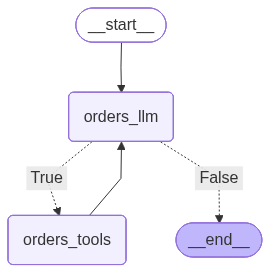

In [42]:
Image(orders_agent.agent_graph.get_graph().draw_mermaid_png())

### Execute the Agent

- Send a sequence of messages to chatbot and get its response
- This simulates the conversation between user and agentic chatbot

In [43]:
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Can you show me the details again ? ",
    "What about order ORD-9999 ?",
    "Bye"
]

#### Create a new Thread

In [44]:
#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [45]:
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = orders_agent.agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : I'm here and ready to assist you with your laptop order inquiries. How can I help you today?
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : Here are the details for order **ORD-7311**:

- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 2
- **Delivery Date:** 2024-10-19

If you need any further assistance, feel free to ask!
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : The quantity for order **ORD-7311** has been successfully updated to 3 units of the NanoEdge Flex laptop. If there's anything else you need, just let me know!
----------------------------------------
USER : Can you show me the details again ? 

AGENT : Here are the updated details for order **ORD-7311**:

- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 3
- **Delivery Date:** 2024-10-19

If you have any mo